In [1]:
import multiprocessing
import os
from functools import partial
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import warnings

import tensorflow as tf
from tensorflow.core.util import event_pb2

warnings.filterwarnings("ignore")

E0000 00:00:1755875164.543017  328238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755875164.547172  328238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import re

BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RUNS_DIR = f"{BASE_DIR}/runs"
TABLES_DIR = f"{BASE_DIR}/results/tables/"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"

# EXP_ID = "ebm-v2-optim-L-20k-a6-fed05"
# EXP_ID = "ebm-v2-optim-L-20k-a6-fed10"
EXP_ID = "ebm-v2-optim-L-20k-a6-nofed"

# EXP_ID = "ebm-v2-optim-L-20k-a2-fed05"
# EXP_ID = "ebm-v2-optim-L-20k-a2-fed10"
# EXP_ID = "ebm-v2-optim-L-20k-a2-nofed"


def extract_version(text):
    pattern = r"(?:\b\w+-)?v\d+"
    match = re.search(pattern, text)
    return match.group(0) if match else None


NUM_STEPS = 200
EPISODE_COUNT = 20000 // NUM_STEPS
N_EXPERIMENTS = 10
TOP_K = 3

algos = ["ddpg", "td3", "tqc"]
num_clients = int(re.search(r"-(?:a|c|ac)(\d+)-", EXP_ID).group(1))

In [5]:
def retrieve_data(algo, cid):
    exp_id = EXP_ID
    tfrecord_paths = glob(
        f"{RUNS_DIR}/{exp_id}_*/*_{algo}_torch__*__{cid}__*/*"
    )
    cntr = 0
    data = {}
    for tfrecord_path in tfrecord_paths:
        seed = int(tfrecord_path.split("/")[-2].split("__")[-3])
        data[seed] = []
        episodic_idx = 0
        flag = False
        serialized_events = tf.data.TFRecordDataset(tfrecord_path)
        for serialized_example in serialized_events:
            e = event_pb2.Event.FromString(serialized_example.numpy())
            for v in e.summary.value:
                if (
                    v.HasField("simple_value")
                    and v.tag == "charts/episodic_return"
                ):
                    episodic_idx += 1
                    data[seed].append(
                        {
                            "episode": episodic_idx,
                            "episodic_return": -v.simple_value,  # Negate here to simplify later processing
                        }
                    )
                    if episodic_idx == 100:
                        flag = True
                        break
            if flag == True:
                break
        cntr += 1
    assert cntr == N_EXPERIMENTS, f"NOT OK ... {algo} | {cid} ... found {cntr}"
    return data


def parallel_retrieve_data(args):
    algo, cid = args
    return algo, cid, retrieve_data(algo, cid)

In [6]:
args_list = [(algo, cid) for algo in algos for cid in range(num_clients)]
with multiprocessing.Pool(processes=os.cpu_count()) as pool:
    results = pool.map(partial(parallel_retrieve_data), args_list)

data = {}
for algo, cid, value in results:
    data.setdefault(algo, {})[cid] = value

In [7]:
def retrieve_plot_data(data, algo, cid):
    plot_data = {}
    cid_episode_data = {}
    for seed_records in data[algo][cid].values():
        for record in seed_records:
            episode = record["episode"]
            if episode not in cid_episode_data:
                cid_episode_data[episode] = []
            cid_episode_data[episode].append(record["episodic_return"])

    cid_episodes = sorted(cid_episode_data.keys())
    returns = [cid_episode_data[cep] for cep in cid_episodes]

    means = [np.mean(x) for x in returns]
    std_devs = [np.std(x) / np.sqrt(N_EXPERIMENTS) for x in returns]
    assert (
        len(means) == len(std_devs) == EPISODE_COUNT
    ), f"EPISODES NOT OK ... {algo} | {cid}"
    return cid_episodes, returns, means, std_devs

In [8]:
def format_func(value, tick_number=None):
    num_thousands = (
        0 if np.abs(value) < 1000 else int(np.floor(np.log10(abs(value)) / 3))
    )
    value = round(value / 1000**num_thousands, 2)
    txt = f"{value:g}" + " KMGTPEZY"[num_thousands]
    return txt

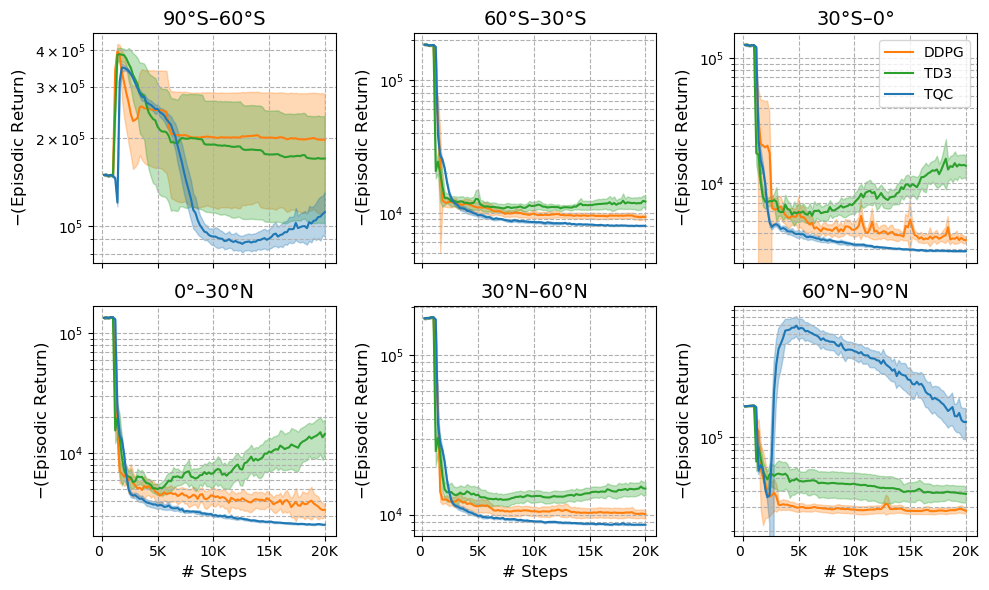

In [9]:
if num_clients == 2:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)
    labels = [
        "90°S–0°",
        "0°–90°N",
    ]

if num_clients == 6:
    fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=False)
    labels = [
        "90°S–60°S",
        "60°S–30°S",
        "30°S–0°",
        "0°–30°N",
        "30°N–60°N",
        "60°N–90°N",
    ]

default_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
algo_colours = {
    "tqc": default_colours[0],  # ebm-v1: blue
    "ddpg": default_colours[1],  # ebm-v1: orange
    "td3": default_colours[2],  # ebm-v1: green
}

axes = axes.flatten()

for cid in range(num_clients):
    ax = axes[cid]
    for idx, algo in enumerate(algos):
        episodes, _, means, std_devs = retrieve_plot_data(data, algo, cid)
        global_steps = [NUM_STEPS * x for x in episodes]

        (line,) = ax.plot(
            global_steps,
            means,
            label=f"{algo.upper()}",
            color=algo_colours.get(algo, "k"),
        )
        ax.fill_between(
            global_steps,
            np.array(means) - 1.96 * np.array(std_devs),
            np.array(means) + 1.96 * np.array(std_devs),
            color=algo_colours.get(algo, "k"),
            alpha=0.3,
        )
    ax.set_title(f"{labels[cid]}", fontsize=14)
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylabel("$-\mathrm{(Episodic~Return)}$", fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=10)
    if (num_clients == 2 and cid >= 0) or (num_clients == 6 and cid >= 3):
        ax.set_xlabel("# Steps", fontsize=12)
    if (num_clients == 2 and cid == 1) or (num_clients == 6 and cid == 2):
        ax.legend(fontsize=10)

plt.tight_layout()

for ext in ["pdf", "png"]:
    plt.savefig(
        f"{IMGS_DIR}/{ext}/{EXP_ID}_log10_cid_episodic_returns.{ext}",
        dpi=300,
        bbox_inches="tight",
    )

plt.show()